# ROI detection with Deep Learning
Notebook used to test ROI detection using Deep Learning with PyTorch.

In [7]:
%matplotlib inline

import os, sys, time, shutil
import random
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa

import torch
# import torchvision
# from torch.utils import data

from utils_common.image import imread_to_float, to_npint, overlay_mask, overlay_preds_targets
from utils_data import normalize_range, get_all_dataloaders, get_filenames, pad_transform, pad_transform_stack
from utils_loss import get_BCEWithLogits_loss
from utils_metric import get_dice_metric, get_crop_dice_metric
from utils_model import weights_initialization, CustomUNet
from utils_train import train, train_plot
from utils_test import predict, predict_stack, evaluate, show_sample

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

Device: cuda:0


## Parameters
Hyperparameters, folder names, etc.

In [8]:
n_epochs = 5
batch_size = 32
learning_rate = 0.001
step_decay = 5 # Number of epochs after which the lr is decayed by a factor 2 (None for no decay)

use_crop_dice = False
crop_dice_scale = 4.0 # scale of the cropping (w.r.t. ROI's bounding box) for the dice coef.

use_weights = True # if False use class weights, if True use pixelwise weights (if existing)

synth_data = False
synth_ratio = None # ratio of synthetic data vs. real data
only_synth = False # If True, will use only the synthetic data (and all of it, at the opposite of ratio=1)

data_aug = False # If True, will use data augmentation (see below for augmentation sequence)

input_channels = "RG" # Channel to use as input
u_depth = 4
out1_channels = 16

model_name = "test"
model_dir = "models/"
data_dir = "/data/talabot/pdm/dataset_cv-annotated/"

## Data loading
Create dataloaders, and build data-related constants.

In [13]:
# Create random augment sequence for data augmentation
if data_aug:
    seq = iaa.Sequential([
        iaa.GammaContrast((0.7, 1.3)) # Gamma correction
    ])
    aug_fn = seq.augment_image
    print("Data augmentation is enabled.")
else:
    aug_fn = lambda x: x # identity function

# Create dataloaders
dataloaders = get_all_dataloaders(
    data_dir,
    batch_size, 
    input_channels = input_channels,
    test_dataloader = True,
    use_weights = use_weights,
    synthetic_data = synth_data, synthetic_ratio = synth_ratio, synthetic_only = only_synth,
    train_transform = lambda img: normalize_range(pad_transform(aug_fn(img), u_depth)), # With possible augmentation
    train_target_transform = lambda img: pad_transform(img, u_depth),
    eval_transform = lambda img: normalize_range(pad_transform(img, u_depth)), 
    eval_target_transform = lambda img: pad_transform(img, u_depth)
)

N_TRAIN = len(dataloaders["train"].dataset)
N_VALID = len(dataloaders["valid"].dataset)
N_TEST = len(dataloaders["test"].dataset)
print("%d images:" % (N_TRAIN + N_VALID + N_TEST))
print("%d to train" % N_TRAIN, end="")
if only_synth:
    print(" (of synthetic data only).")
elif synth_data:
    if synth_ratio is None:
        print(" (with synthetic data)")
    else:
        print(" (with %d%% of synthetic data)" % (synth_ratio * 100))
else:
    print("")
print("%d to validation" % N_VALID)
print("%d to test" % N_TEST)

# Compute class weights (as pixel imbalance) takes ~90s for 78 stacks
if use_weights:
    print("Pixel-wise weighting enabled")
pos_count = 0
neg_count = 0
for filename in dataloaders["train"].dataset.y_filenames:
    y = io.imread(filename)
    pos_count += (y == 255).sum()
    neg_count += (y == 0).sum()
pos_weight = torch.tensor((neg_count + pos_count) / (2 * pos_count)).to(device)
neg_weight = torch.tensor((neg_count + pos_count) / (2 * neg_count)).to(device)
print("{} ROI pixels, and {} background".format(pos_count, neg_count))
print("  --> {:f} positive weighting".format(pos_weight))
print("  --> {:f} negative weighting".format(neg_weight))

28800 images:
18000 to train
6000 to validation
4800 to test
Pixel-wise weighting enabled
11126882 ROI pixels, and 873609118 background
  --> 39.756691 positive weighting
  --> 0.506368 negative weighting


## Model definition
Define model, loss, metrics, and optimizer.

In [14]:
model = CustomUNet(len(input_channels), u_depth=u_depth, 
                   out1_channels=out1_channels, batchnorm=True, device=device)
print(model)
# (Optional) load weights from existing model
# model.load_state_dict(torch.load("models/unet4-16_RG_cv-annotated_aug/model_best.pth"))

# Save the "architecture" of the model by copy/pasting the class definition file
os.makedirs(os.path.join(model_dir, model_name), exist_ok=True)
shutil.copy("utils_model.py", os.path.join(model_dir, model_name, "utils_model_save.py"))

loss_fn = get_BCEWithLogits_loss(pos_weight=pos_weight, neg_weight=neg_weight)

metrics = {"dice": get_dice_metric()}
if use_crop_dice:
    metrics.update({"diC%.1f"%crop_dice_scale: get_crop_dice_metric(scale=crop_dice_scale)})

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if step_decay is not None:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_decay, gamma=0.5)
else:
    scheduler = None

CustomUNet(
  (activation): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convs): ModuleList(
    (0): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): UNetConv(
      (activation): ReLU()
      (co

## Training

In [ ]:
best_model, history = train(model,
                            dataloaders,
                            loss_fn,
                            optimizer,
                            n_epochs,
                            scheduler = scheduler,
                            metrics = metrics,
                            criterion_metric = None,#"dice",
                            model_dir = os.path.join(model_dir, model_name),
                            replace_dir = True,
                            verbose = 1)

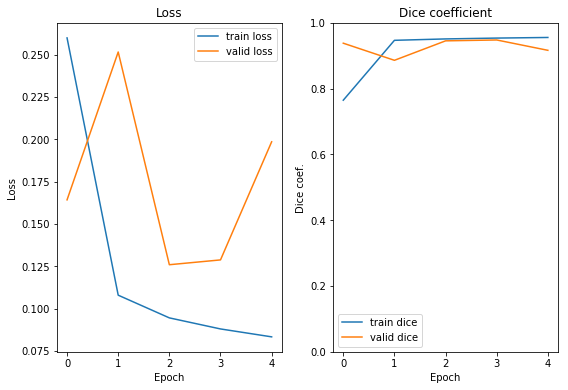

In [6]:
fig = train_plot(history, crop_dice=use_crop_dice, scale_crop=crop_dice_scale)
fig.show()

## Testing
Test and visualize best model on valid/test data. Note that this is for debugging purposes: you should use the test data only at the very end! Otherwise, just use validation data.

In [15]:
# Load best model /!\ Always check which class to import !
name_test = "RG_synth_190311"
# name_test = "unet4-16_RG_cv-annotated_aug"
# name_test = "unet4-16_synth_only_2-6neur_181205"
sys.path.append(os.path.join(model_dir, name_test))

from utils_model_save import CustomUNet as ModelNet

best_model = ModelNet(len(input_channels), u_depth=u_depth, 
                      out1_channels=out1_channels, batchnorm=True, device=device)
best_model.load_state_dict(torch.load(os.path.join(model_dir, name_test, "model_best.pth")))
best_model.eval()

CustomUNet(
  (activation): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convs): ModuleList(
    (0): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): UNetConv(
      (activation): ReLU()
      (co

In [6]:
# Evaluate over a dataloader
ev_metrics = evaluate(best_model, dataloaders["valid"], 
                        {"loss": loss_fn, **metrics})
print("Loss = {}\nDice = {}".format(ev_metrics["loss"], ev_metrics["dice"]) + \
      ("\nDiC{:.1f} = {}".format(crop_dice_scale, ev_metrics["diC%.1f"%crop_dice_scale]) if use_crop_dice else ""))

Loss = 0.12155498906970025
Dice = 0.9420249748229981


Image   2327 (/data/talabot/pdm/dataset_cv-annotated/validation/MAN-2_image_MAN1_tdTom-GC6s_fly2_023/rgb_frames/rgb_0527.png): 
dice = 0.973856 - 
Image   2347 (/data/talabot/pdm/dataset_cv-annotated/validation/MAN-2_image_MAN1_tdTom-GC6s_fly2_023/rgb_frames/rgb_0547.png): 
dice = 0.938307 - 
Image   3234 (/data/talabot/pdm/dataset_cv-annotated/validation/MAN-4_imaging_MAN1_fly3_007/rgb_frames/rgb_0234.png): 
dice = 0.964995 - 
Image   3722 (/data/talabot/pdm/dataset_cv-annotated/validation/MDN1-1_image_MDN1_tdTom-GC6s_005/rgb_frames/rgb_0122.png): 
dice = 0.953621 - 


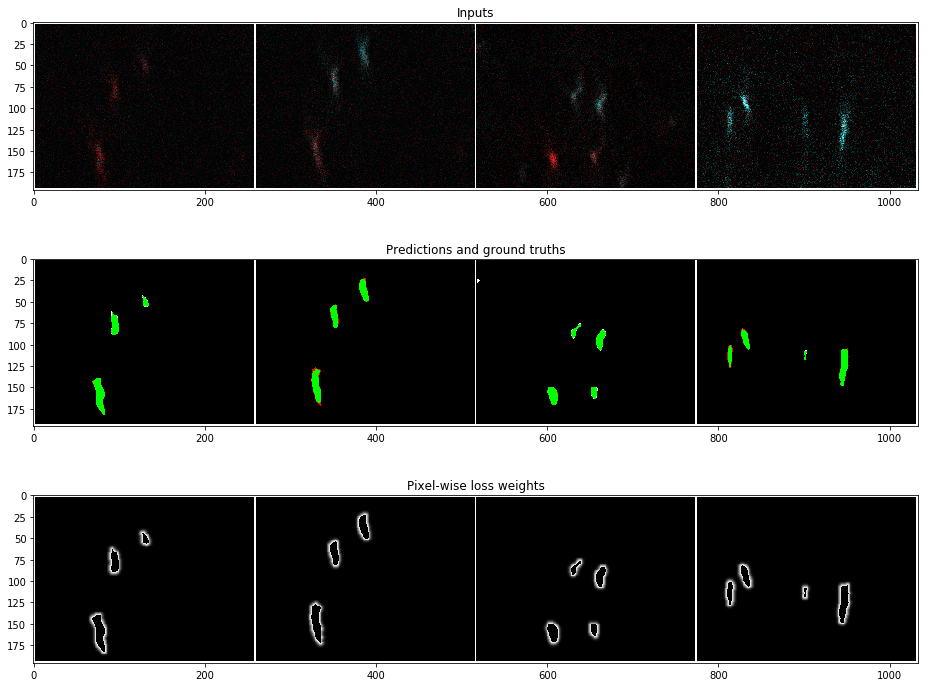

In [16]:
show_sample(best_model, dataloaders["valid"], n_samples=4, metrics = metrics)

### Test on a full stack

In [7]:
# exp_name = "/data/talabot/experiments/to_annotate/R85A02_20180716_tdTomGC6fopt-fly4/R85A02_20180716_tdTomGC6fopt-fly4-001/"
# exp_name = "/data/talabot/pdm/dataset_cv-annotated/validation_fail/A1_S47-3_fly1_S47_tdTom-GC6s_fly3_011/"
exp_name = "/mnt/NAS/Ascending_Project/R13G06/2P/20190117/R13G06-tdTomGC6fopt-fly1/R13G06-tdTomGC6fopt-fly1-001/2Pimg/"

rgb_stack = imread_to_float(os.path.join(exp_name, "RGB.tif"))
try:
    seg_stack = imread_to_float(os.path.join(exp_name, "seg_ROI.tif"))
except FileNotFoundError:
    seg_stack = None
channels = {"R": rgb_stack[...,0], "G": rgb_stack[...,1], "B": rgb_stack[...,2]}
stack = np.stack([channels[channel] for channel in input_channels], axis=1)

### Optional normalization/transform ###
transform = lambda stack: normalize_range(pad_transform_stack(stack, u_depth))

start_predict = time.time()
predictions = predict_stack(best_model, stack, batch_size, input_channels=input_channels, transform=transform)
print("Prediction took %.1fs." % (time.time() - start_predict))

if seg_stack is not None:
    print("dice = %.3f" % metrics["dice"](predictions[:len(seg_stack)], torch.from_numpy(seg_stack)))
    if use_crop_dice:
        print("cropped dice = %.3f" % metrics["diC%.1f"%crop_dice_scale](predictions[:len(seg_stack)], torch.from_numpy(seg_stack)))

predictions = torch.sigmoid(predictions)
@interact(num = widgets.IntSlider(min=0, max=len(rgb_stack) - 1, description='image:'))
def plot_stack_img(num=0):
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    plt.title("RGB data")
    plt.imshow(rgb_stack[num])
    plt.subplot(222)
    plt.title("Input")
    if input_channels == "R":
        plt.imshow(rgb_stack[num,...,0], vmin=0, vmax=1, cmap="gray")
    if input_channels == "G":
        plt.imshow(rgb_stack[num,...,1], vmin=0, vmax=1, cmap="gray")
    elif input_channels == "RG":
        plt.imshow(rgb_stack[num], vmin=0, vmax=1)
    plt.subplot(223)
    plt.title("Prediction (max = %.1f)" % predictions[num].max())
    plt.imshow(predictions[num], vmin=0, vmax=1, cmap="gray")
    plt.subplot(224)
    plt.title("Binary reduction")
    plt.imshow(predictions[num] > 0.5, vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.show()
    
    if seg_stack is not None and num < len(seg_stack):
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.title("Target")
        plt.imshow(seg_stack[num], cmap="gray")
        plt.subplot(122)
        plt.title("Overlap")
        plt.imshow(overlay_preds_targets((predictions[num] > 0.5).numpy().astype(np.float), seg_stack[num]))
        plt.tight_layout()
        plt.show()

Prediction took 1.7s.


interactive(children=(IntSlider(value=0, description='image:', max=1066), Output()), _dom_classes=('widget-int…